# はじめに

このノートでは、lightGBMのアルゴリズムに関して、基本的な部分をおさらいして、まとめている。下記の書籍のコードと論文を参考にしている。

- [LightGBM予測モデル実装ハンドブック](https://www.shuwasystem.co.jp/book/9784798067612.html)
- [LightGBM: A Highly Efficient Gradient Boosting Decision Tree](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)

今回はlightGBMで2値分類をどのように行うかに焦点をあてている。

## モデルの学習

必要なライブラリをインポートしておく。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

ここで使用するデータは、1994年のアメリカの国勢調査に関するサンプルデータ。データの説明は下記の通り。`income`が目的変数で5万ドルを基準に2つに分割されている。

|変数|説明|
|:---|:---|
|`age`| 年齢|
|`workclass`| 雇用形態|
|`fnlwgt`| ？|
|`education`| 学歴|
|`education-num`| 教育年数|
|`marital-status`| 配偶者のありなし|
|`occupation`| 職業|
|`relationship`| 世帯内の関係|
|`race`| 人物|
|`gender`| 性別|
|`capital-gain`| キャピタルゲイン|
|`capital-loss`| キャピタルロス|
|`hours-per-week`| 1週間の労働時間|
|`native-country`| 母国|
|`income`| 収入(<=50Kは5万ドル以下、>50kは5万ドル超え)|


In [2]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
df.columns =['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


このデータの特徴量の大部分なので、モデルで利用しやすい形に修正する必要がある。

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   gender          32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


各特徴量のユニークな値を計算すると、多いもので42のユニークな値をもつ特徴量が存在している。

In [4]:
# 各カテゴリ列のユニークな値の数を数える
unique_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':
        unique_counts[col] = df[col].nunique()

# 結果を出力する
for col, count in unique_counts.items():
    print(f'{col}:', count)

workclass: 9
education: 16
marital-status: 7
occupation: 15
relationship: 6
race: 5
gender: 2
native-country: 42
income: 2


実際の値は下記の通り。` ?`のように半角スペースやはてな記号が用いられているケースが散見される。

In [5]:
# カテゴリ変数のリスト表示
cat_cols = list(unique_counts.keys())

for col in cat_cols:
    print('%s: %s' % (col, list(df[col].unique())))

workclass: [' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked']
education: [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th', ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th']
marital-status: [' Never-married', ' Married-civ-spouse', ' Divorced', ' Married-spouse-absent', ' Separated', ' Married-AF-spouse', ' Widowed']
occupation: [' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners', ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair', ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct', ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces', ' Priv-house-serv']
relationship: [' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried', ' Other-relative']
race: [' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' Other']
gender: [' Male', ' Female']
native-

各特徴量の分布も確認しておく。

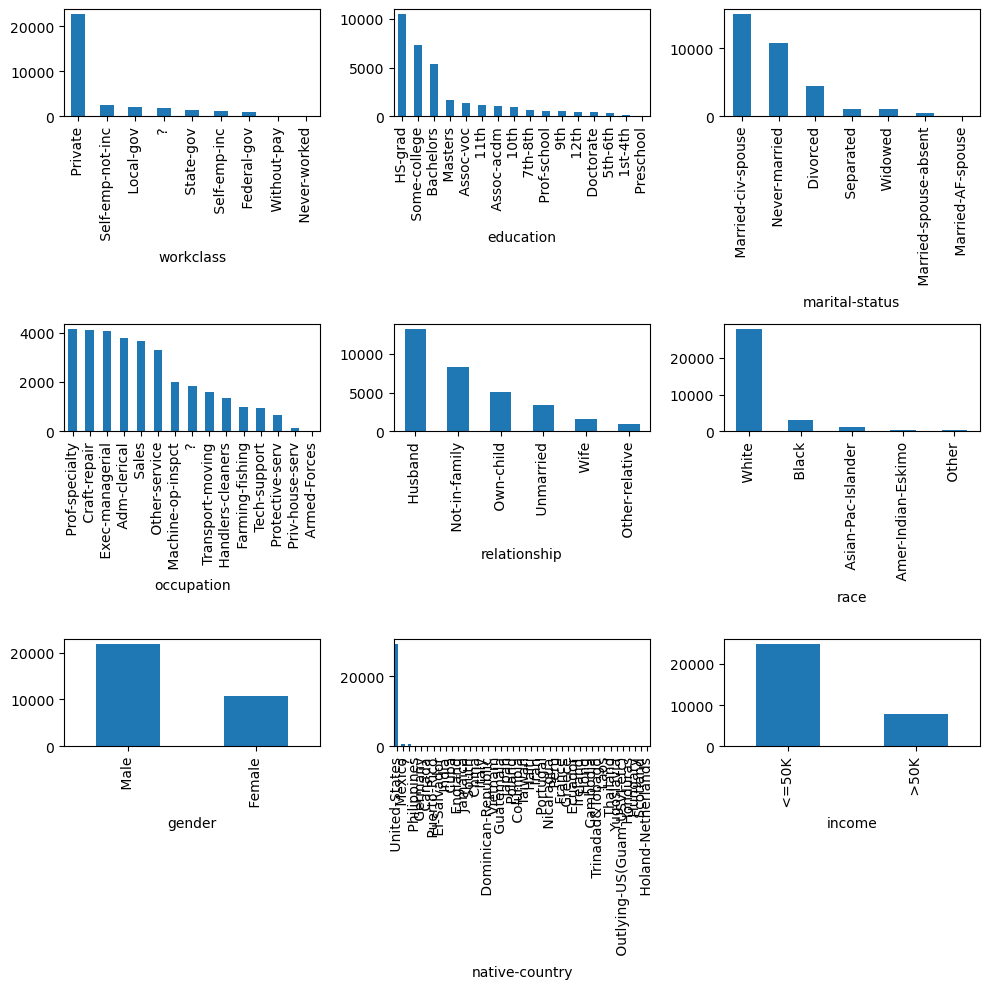

In [6]:
plt.rcParams['figure.figsize'] = (10, 10)

for i, name in enumerate(cat_cols):
  ax = plt.subplot(3, 3, i+1)
  df[name].value_counts().plot(kind='bar', ax=ax)

plt.tight_layout() 
plt.show()

モデルに取り込む前に、文字列に含まれている半角スペースを修正したり、アメリカのデータにだけ絞り込んでおく。

In [7]:
# 前処理
# 文字列の半角スペース削除
for s in cat_cols:
  df[s] =df[s].str.replace(' ', '')

# United-Statesのレコードに絞り特徴量native-countryを削除
df = df[df['native-country'].isin(['United-States'])]
df = df.drop(['native-country'], axis=1)
df.reset_index(inplace=True, drop=True)

# 正解ラベルの数値への置換
df['income'] = df['income'].replace('<=50K', 0)
df['income'] = df['income'].replace('>50K', 1)

print(df.shape)
df.head()

(29170, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,0


学習データとテストデータに分割し、モデルを構築していく。

In [8]:
# 特徴量と目的変数の設定
X = df.drop(['income'], axis=1)
y = df['income']

# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (23336, 13)  y_trainの形状： (23336,)  X_testの形状： (5834, 13)  y_testの形状： (5834,)


決定木系のモデルではカテゴリ変数を数値に変換して利用することが一般的なので、ラベルエンコーディングを行う。ラベルエンコーディングは文字を数字の連番に置き換えるだけ。実際のところ、LightGBMはカテゴリ変数を文字のまま渡してもよしなにやってくれるため、わざわざラベルエンコーディングをする必要はない。SHAPなどを利用する場合は数字でないと扱えないので処理しておく必要がある。

In [9]:
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23336 entries, 14415 to 5640
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             23336 non-null  int64
 1   workclass       23336 non-null  int64
 2   fnlwgt          23336 non-null  int64
 3   education       23336 non-null  int64
 4   education-num   23336 non-null  int64
 5   marital-status  23336 non-null  int64
 6   occupation      23336 non-null  int64
 7   relationship    23336 non-null  int64
 8   race            23336 non-null  int64
 9   gender          23336 non-null  int64
 10  capital-gain    23336 non-null  int64
 11  capital-loss    23336 non-null  int64
 12  hours-per-week  23336 non-null  int64
dtypes: int64(13)
memory usage: 2.5 MB


In [10]:
X_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week
14415,33,4,460408,11,9,4,12,1,4,1,3325,0,50
24513,21,7,96483,15,10,4,1,3,1,0,0,0,12
14065,37,4,125933,7,12,2,4,0,4,1,7688,0,50
24412,28,4,242482,11,9,2,12,0,4,1,0,0,40
664,42,4,151408,12,14,4,4,1,4,0,14084,0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,49,1,168232,11,9,2,1,0,4,1,0,0,40
170,40,1,56795,12,14,4,4,1,4,0,14084,0,55
25493,55,6,100569,11,9,5,5,4,4,0,0,0,55
2658,23,4,268525,9,13,4,10,1,4,1,0,0,50


ラベルエンコーディングで変換した値はint型になっているので、LightGBMの仕様に合わせてPandasのCategory型に変換しておく。

In [11]:
# カテゴリ変数のデータ型をcategory型に変換
for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23336 entries, 14415 to 5640
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             23336 non-null  int64   
 1   workclass       23336 non-null  category
 2   fnlwgt          23336 non-null  int64   
 3   education       23336 non-null  category
 4   education-num   23336 non-null  int64   
 5   marital-status  23336 non-null  category
 6   occupation      23336 non-null  category
 7   relationship    23336 non-null  category
 8   race            23336 non-null  category
 9   gender          23336 non-null  category
 10  capital-gain    23336 non-null  int64   
 11  capital-loss    23336 non-null  int64   
 12  hours-per-week  23336 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 1.4 MB


ここでの評価指標はLogLossを利用する。LogLossは下記の通り計算される評価指標で小さければ小さいほどよい。Accuracyが「分類の正確性」を表す一方、LogLossは「予測の確実性の高さ」を表している。0.5をしきい値とした場合、予測値が0.99も0.51も同様に正解とカウントされてしまうため、この問題を修正した評価指標となっている。

$$
logloss=- \frac{1}{N} \sum ^{n}_{i=1}y_i\log{p_i}+(1-y_i)\log{(1-p_i)}
$$

下記のデータと結果が得られたとする。このとき、LogLossは予測の確信度合いをスコアに反映させる。確信度合いとは、正解ラベルと予測確率の差である。No1,2は正解ラベルが1なので、1を予測する確率が高ければ高いほうがよく、差が小さくなる。逆にNo3,4は正解ラベルが0なので、0に近いほうが正解確率が高いため、予測値を反転させる。下記の表を見るとわかるが、正解ラベルに対して、確率が大きければ(小さければ)、LogLossの値は小さくなるが、No4のように、正解ラベルに対して確信度合い高く予測を外している場合、ペナルティは非常に大きくなる。この場合のLogLossは`(0.051 + 0.693 + 0.105 + 1.609)/4 = 0.6145`である。

|No|label|prob|diff| -log(p') |
|:---|:---|:---|:---|:---|
|1|1|0.95|0.05|0.051|
|2|1|0.50|0.50|0.693|
|3|0|0.10|1-0.10=0.9|0.105|
|4|0|0.80|1-0.80=0.2|1.609|

In [12]:
import math
from sklearn.metrics import log_loss

actual_labels = [1,1,0,0]
predicted_probabilities = [0.95,0.50,0.10,0.80]

print('Binary Log Loss(sklearn):', log_loss(actual_labels, predicted_probabilities))
print('----------------------------------------------')

log_loss_sum = 0
for i in range(len(actual_labels)):
    y = actual_labels[i]
    p = predicted_probabilities[i]
    
    log_loss_sum += (y * math.log(p) + (1 - y) * math.log(1 - p))

print('Binary Log Loss:', -log_loss_sum / len(actual_labels))



Binary Log Loss(sklearn): 0.6148097257598557
----------------------------------------------
Binary Log Loss: 0.6148097257598557


準備が整ったので、モデルを学習する。

In [13]:
lgb_train = lgb.Dataset(X_train, y_train)

params = {
    'objective': 'binary',     # 2値交差エントロピー
    'metri': 'binary_logloss', # クロスエントロピー
    'num_leaves': 5,           # 葉数の最大値
    'seed': 0,
    'verbose': -1,
}

# モデルの学習
model = lgb.train(
  params,
  lgb_train,
  num_boost_round=5000,
  valid_sets=[lgb_train],
  valid_names=['train'],
  callbacks=[lgb.log_evaluation(1000)]
  )


[1000]	train's binary_logloss: 0.237075
[2000]	train's binary_logloss: 0.211398
[3000]	train's binary_logloss: 0.192698
[4000]	train's binary_logloss: 0.177526
[5000]	train's binary_logloss: 0.163726


分類の場合、予測値はラベルが1の確率を返す。

In [14]:
# テストデータの予測と評価
y_test_pred_proba = model.predict(X_test) # ラベル1の確率
print('ラベル1の確率：', y_test_pred_proba)


ラベル1の確率： [0.00268537 0.15200524 0.57619415 ... 0.9984948  0.03303417 0.0331655 ]


ラベルにしたい場合は変換する必要がある。

In [15]:
y_test_pred = np.round(y_test_pred_proba) # 確率をラベル0 or 1に変換
print('予測ラベル値：', y_test_pred)

予測ラベル値： [0. 0. 1. ... 1. 0. 0.]


ここでは、AccuracyとF1スコア、LogLossで評価している例を乗せておく。

In [16]:
ac_score = accuracy_score(y_test, y_test_pred)
print('accuracy = %.2f' % (ac_score))

f1 = f1_score(y_test, y_test_pred)
print('F1-score = %.2f' % (f1))

ll = log_loss(y_test, y_test_pred_proba)
print('Log Loss = %.2f' % (ll))


accuracy = 0.86
F1-score = 0.69
Log Loss = 0.31


最後にモデルの重要度を確認すると、`relationship`が重要となっている。

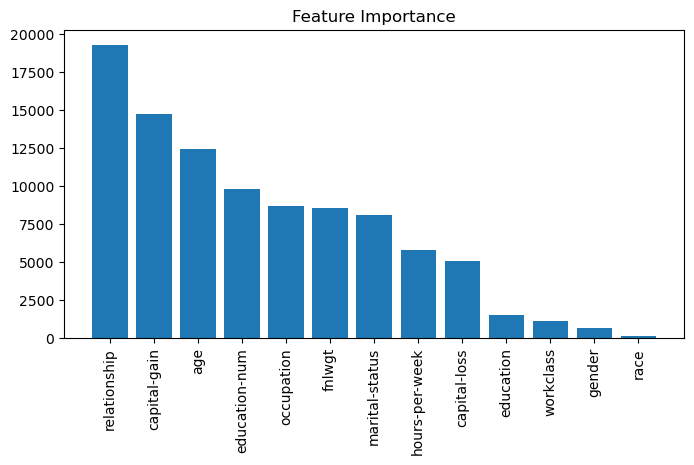

In [17]:
# 特徴量重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量重要度
indices = np.argsort(importances)[::-1] # 特徴量重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title("Feature Importance") # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示